# Redes Neuronales Recurrentes

A lo largo de este notebook de prácticas haremos varios ejemplos, tanto con RNNs básicas como con LSTMs, y veremos las diferencias.

También trabajaremos con problemas con una única variable y con problemas multivariantes.

# 1. Predicción de demanda de vuelos en una aerolinea

El primer problema que abordaremos es el de tratar de predecir los viajeros de una determinada aerolinea. Para ello, carguaremos los datos y los transformaremos de forma que podamos utilizarlos con nuestros modelos.

In [1]:
# Nos descargamos los datos
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2021-03-27 11:45:37--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2021-03-27 11:45:37 (39.3 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



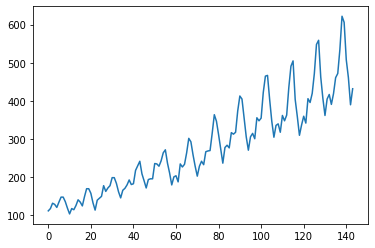

In [2]:
# Y los visualizamos
import pandas
import matplotlib.pyplot as plt
dataset_raw = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset_raw)
plt.show()

### **Transformación de los datos**

Ahora necesitamos convertir los datos de forma que la RNN pueda usarlos. Daos cuenta de que por el momento tenemos únicamente un conjunto de valores secuenciales, pero vamos a querer aplicar un algoritmo supervisado (las RNNs lo son).

Así que... ¿Dónde están las etiquetas?

¡En los propios datos!

Nosotros tenemos esto:

<img src="https://miro.medium.com/max/1400/1*nhffHtudbkqG0yYIF3oeBA.png">

Donde la etiqueta para una determinada secuencia de longitud N será la muestra N+1:

<img src="https://miro.medium.com/max/1400/1*murkc0tNsvgdQDVgKqSdfQ.png">

Y esta transformación de datos es muy sencilla con Python:

In [3]:
# convertimos los datos a un formato entendible por la RNN
import numpy as np

def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return np.array(dataX), np.array(dataY)

Imaginémonos que queremos, a partir de un valor, predecir el siguiente. Es decir, tendríamos un "ventana" de un único elemento. Para ello, tendríamos que hacer lo siguiente:

In [4]:
dataX, dataY = create_dataset(dataset_raw.values, look_back_memory=1)
print(dataX.shape)
print(dataY.shape)

(142, 1)
(142,)


¡Atención! Esto no significa que nuestra memoria sea de un elemento. Recordad que las RNNs tienen una "cinta transportadora" (estado) en la que acumulan información. Por lo tanto, lo único que indica esta ventana, es la cantidad de muestras en la que se basará para hacer la predicción en cada instante temporal.

Pero luego, la RNN, podrá almacenar información de varias de esas predicciones.

Si quisieramos que nuestra RNN utilizara más de una muestra para cada predicción, tendríamos que aumentar el tamaño de la ventana de 1 a N. Esto podríamos hacerlo modificando el valor de `loop_back_memory`.

In [5]:
# Por ejemplo, para una ventana de 10 elementos:
dataX, dataY = create_dataset(dataset_raw.values, look_back_memory=10)
print(dataX.shape)
print(dataY.shape)

(133, 10)
(133,)


###**Predicción con una RNN básica**

Ahora que ya sabemos como transformar los datos al formato pertinente, podemos comenzar a implementar el modelo. En este caso, utilizaremos una red recurrente con una celda y 10 neuronas, seguida de una capa densa con activación lineal (recordad que estamos haciendo regresión).

In [6]:
import numpy

def create_dataset(dataset, look_back_memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back_memory-1):
        dataX.append(dataset[i:i+look_back_memory, 0])
        dataY.append(dataset[i+look_back_memory, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [7]:
# hacemos el import de todo lo que utilizaremos
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
# fijamos la semilla para obtener resultados reproducibles
numpy.random.seed(42)

In [9]:
# cargamos los datos
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [10]:
# normalizamos el dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# dividimos en train y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
# transformamos los datos para crearnos N registros con T timestamps cada uno 
# (uno por cada instante temporal hasta completar el tamaño de la ventana) y 
# las V variables de las que disponga nuestro dataset. En este caso, vamos a 
# escoger una ventana con un único timestamp T=1 y solo tendremos una variable,
# con lo que V=1 (número de pasajeros).
look_back_memory = 1
trainX, trainY = create_dataset(train, look_back_memory)
testX, testY = create_dataset(test, look_back_memory)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(94, 1) (94,)
(46, 1) (46,)


In [13]:
# Nos aseguramos de que las dimensiones de las entradas son las correctas:
# (número de ventanas de T elementos, los T elementos de cada ventana, las V variables de cada timestamp)
variables = 1 # (trainX.shape[1])
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back_memory, variables))
testX = numpy.reshape(testX, (testX.shape[0], look_back_memory, variables))
print(trainX.shape)
print(testX.shape)

(94, 1, 1)
(46, 1, 1)


In [14]:
# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(SimpleRNN(10, input_shape=(1, look_back_memory)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 1s 1ms/step - loss: 0.0544
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0034
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 10/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 11/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 12/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 13/100
94/94 [=================

In [15]:
# vamos a ver qué tal funciona nuestro modelo
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [16]:
trainPredict.shape

(94, 1)

In [17]:
trainY.shape

(94,)

In [18]:
# una vez hechas las predicciones, tenemos que des-normalizarlas
trainPredict = scaler.inverse_transform(trainPredict)
trainY_orig = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_orig = scaler.inverse_transform([testY])

In [19]:
# y ahora calculamos el error cometido en train y en test
trainScore = math.sqrt(mean_squared_error(trainY_orig[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_orig[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.80 RMSE
Test Score: 46.83 RMSE


In [20]:
# por como creamos el dataset de entrenamiento, ahora tenemos que desplazar
# nuestras predicciones para que "cuadren" con el eje x de los datos originales
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back_memory:len(trainPredict)+look_back_memory, :] = trainPredict

In [21]:
# y lo mismo para el test
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back_memory*2)+1:len(dataset)-1, :] = testPredict

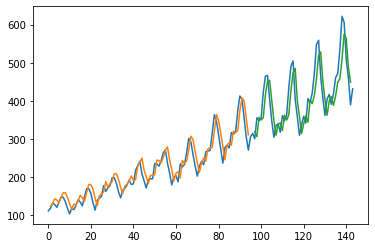

In [22]:
# y mostramos los datos originales, la predicción en training y la predicción en test
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Estos resultados son los que hemos conseguido con una RNN básica. ¿Os animáis a probar con una LSTM?

###**Ejercicio 1**

Acabamos de entrenar un modelo RNN para predecir la demanda de vuelos por día. Ahora os toca a vosotros: en vez de utilizar la celda RNN, utilizad la LSTM con exactamente la misma configuración.

In [23]:
from keras.layers import LSTM

# creamos el modelo y lo entrenamos
model = Sequential() #initialize model
model.add(LSTM(10, input_shape=(1, look_back_memory)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 2s 1ms/step - loss: 0.0493
Epoch 2/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0206
Epoch 3/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 4/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 5/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 6/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0136
Epoch 7/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 8/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 9/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 10/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 11/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0045
Epoch 12/100
94/94 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 13/100
94/94 [=================

###**Ejercicio 2** 

Entrena un modelo RNN básico igual al primero, pero con una ventana de 10 timestamps.

Cambiaremos el look back memory

### **Ejercicio 3**

Hemos visto que con la RNN y una ventana de 10 timestamps podemos mejorar los resultados obtenidos con una ventana de 1 timestamp. ¿Se os ocurre como intentar mejorar estos resultados?

Sabemos que las RNN básicas sufren problemas de memoria, y que las LSTM son capaces de mitigarlos. Además, hemos comprobado de forma práctica que las LSTMs consiguen un mejor ajuste.

Entrena una LSTM (https://keras.io/api/layers/recurrent_layers/lstm/) con los datos anteriores, una ventana de 10 timestamps y sin rellenar los T timestamps iniciales con 0's.